In [2]:
import time
print("Current time is:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Current time is: 2025-05-06 17:17:19


In [3]:
import torch 

import numpy as np
import pandas as pd
import xarray as xr
import dask
import os, sys
import glob
import zarr
from joblib import Parallel, delayed
import os
import dask.array as da
from scipy.spatial import cKDTree

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import RTMA_sparse_to_dense_Dataset, Transform
from losses import MaskedMSELoss, MaskedRMSELoss, MaskedTVLoss, MaskedCharbonnierLoss, MaskedPSNR, MaskedSSIM

FIG_DIR = 'Figures'

In [4]:
from matplotlib.colors import ListedColormap
turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
turbo_cmap = ListedColormap(turbo_colormap_data, name="turbo")

- The output on test data are already computed and saved into zarrs, while training. 
- I could call the saved trained models and compute the output, but that needs additional effort, since conversion of inputs is always expensive.
- The idea is not to load the all inputs, except for the orography, mask, and station points (staiton_mask).

In [5]:
# === Loading some topography and masking data ===
orography = xr.open_dataset('orography.nc').orog
RTMA_lat = orography.latitude.values    # Nx, Ny 2D arrays
RTMA_lon = orography.longitude.values   # Nx, Ny 2D arrays
orography = orography.values

mask = xr.open_dataset('mask_2d.nc').mask
mask_tensor = torch.tensor(mask.values.astype(np.float32))

# Initiate the metrics
metrics = {
    'masked_rmse': MaskedRMSELoss(mask_tensor), 
    'masked_psnr': MaskedPSNR(mask_tensor),
    'masked_ssim': MaskedSSIM(mask_tensor),
}

# Load NYSM station data
nysm = pd.read_csv('nysm.csv')
# NYSM station lat/lon
nysm_latlon = np.stack([
    nysm['lat [degrees]'].values,
    (nysm['lon [degrees]'].values + 360) % 360
], axis=-1) # shape: (N, 2)

# Precompute grid KDTree
grid_points = np.stack([RTMA_lat.ravel(), RTMA_lon.ravel()], axis=-1)
tree = cKDTree(grid_points)
# Query the station locations
_, indices_flat = tree.query(nysm_latlon)
# Convert flat indices to 2D (y, x)
y_indices, x_indices = np.unravel_index(indices_flat, orography.shape)

zarr_store = 'data/RTMA.zarr'

In [6]:
var = 'i10fg'
missing_times = xr.open_dataset(f'nan_times_{var}.nc').time
for var in ['si10','t2m','sh2']:
    missing_times = xr.concat([missing_times, xr.open_dataset(f'nan_times_{var}.nc').time], dim='time')
# remove duplicates
missing_times = missing_times.drop_duplicates('time')
missing_times = missing_times.sel(time=slice('2023-01-01T00','2023-12-31T23'))
missing_times       # furtunately, only one time instance is missing, that too in si10.

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2023-01-17T16:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-01-17T16:00:00

# Metrics from Barnes Interpolation

In [22]:
'''
station_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)
station_mask[y_indices, x_indices] = 1  # Set 1 at the station locations
print('Station mask shape:',station_mask.shape)
test_dates_range = ['2023-01-01T00','2023-12-31T23']
variable = 'i10fg'
global_seed = 42
experiments = [
'all-stations',
f'{global_seed}/100-random-stations',
f'{global_seed}/75-random-stations',
f'{global_seed}/50-random-stations',
]
target_ds = xr.open_zarr(zarr_store)[variable].sel(time=slice(*test_dates_range))
target_ds = target_ds.drop_sel(time=missing_times)
results = []
for experiment in experiments:
    interp_ds = xr.open_zarr(f'data/Barnes_interpolated/{experiment}.zarr')[variable].sel(time=slice(*test_dates_range))
    interp_ds = interp_ds.drop_sel(time=missing_times)

    # Convert [T, H, W] -> [B, 1, H, W]
    target_tensor = torch.tensor(target_ds.values, dtype=torch.float32).unsqueeze(1)
    interp_tensor = torch.tensor(interp_ds.values, dtype=torch.float32).unsqueeze(1)
    interp_tensor = interp_tensor.where(~torch.isnan(interp_tensor), 0.0)  # Replace NaNs with 0.0
    station_mask_tensor = torch.tensor(station_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(len(target_tensor), -1, -1, -1)  # [8760, 1, H, W]

    #print('nan_indices:',nan_indices)
    for key in metrics.keys():
        metric_value = metrics[key](interp_tensor, target_tensor, station_mask_tensor).item()
        print(f'{key}: {metric_value:.4f}')

        # Save the results
        results.append({
                "Experiment": experiment.strip(f'{global_seed}/'),
                "Metric": key,
                "Value": metric_value
            })
        
# Convert results to DataFrame
results_df = pd.DataFrame(results)
# Save the results to a CSV file
results_df.to_csv('Barnes_interpolated_metrics.csv', index=False)
'''

'\nstation_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)\nstation_mask[y_indices, x_indices] = 1  # Set 1 at the station locations\nprint(\'Station mask shape:\',station_mask.shape)\ntest_dates_range = [\'2023-01-01T00\',\'2023-12-31T23\']\nvariable = \'i10fg\'\nglobal_seed = 42\nexperiments = [\n\'all-stations\',\nf\'{global_seed}/100-random-stations\',\nf\'{global_seed}/75-random-stations\',\nf\'{global_seed}/50-random-stations\',\n]\ntarget_ds = xr.open_zarr(zarr_store)[variable].sel(time=slice(*test_dates_range))\ntarget_ds = target_ds.drop_sel(time=missing_times)\nresults = []\nfor experiment in experiments:\n    interp_ds = xr.open_zarr(f\'data/Barnes_interpolated/{experiment}.zarr\')[variable].sel(time=slice(*test_dates_range))\n    interp_ds = interp_ds.drop_sel(time=missing_times)\n\n    # Convert [T, H, W] -> [B, 1, H, W]\n    target_tensor = torch.tensor(target_ds.values, dtype=torch.float32).unsqueeze(1)\n    interp_tensor = torch.tensor(interp_ds.values, dtype=torch.float

In [18]:
pd.read_csv('Barnes_interpolated_metrics.csv')

,Experiment,Metric,Value
0,all-stations,masked_rmse,1.343422
1,all-stations,masked_psnr,33.164623
2,all-stations,masked_ssim,0.932487
3,100-random-stations,masked_rmse,1.343422
4,100-random-stations,masked_psnr,33.164623
5,100-random-stations,masked_ssim,0.932487
6,75-random-stations,masked_rmse,1.343422
7,75-random-stations,masked_psnr,33.164623
8,75-random-stations,masked_ssim,0.932487
9,50-random-stations,masked_rmse,1.343422


# Sensitivity experiments of input channels

In [7]:
'''
results = []

station_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)
station_mask[y_indices, x_indices] = 1  # Set 1 at the station locations
print('Station mask shape:',station_mask.shape)
test_dates_range = ['2023-01-01T00','2023-12-31T23']
variable = 'i10fg'
models = ['DCNN','UNet','SwinT2UNet']
experiments = ['no-additional-channels',
               'orography',
               'orography-si10',
               'orography-si10-t2m',
               'orography-si10-t2m-sh2']
for model in models:
    for experiment in experiments:
        test_zarr_store = f'checkpoints/{variable}/{model}/{experiment}/2018-2021/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        target_ds = xr.open_zarr(zarr_store)[variable].sel(time=slice(*test_dates_range))
        pred_ds = xr.open_zarr(test_zarr_store)[variable].sel(time=slice(*test_dates_range))        
        # Convert [T, H, W] -> [B, 1, H, W]
        target_tensor = torch.tensor(target_ds.values, dtype=torch.float32).unsqueeze(1)
        pred_tensor = torch.tensor(pred_ds.values, dtype=torch.float32).unsqueeze(1)
        station_mask_tensor = torch.tensor(station_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(8760, -1, -1, -1)  # [8760, 1, H, W]
        #print('model:',model, 'experiment:',experiment, 'target shape:', target_tensor.shape, 'prediction shape:', pred_tensor.shape, 'station mask shape:', station_mask_tensor.shape)
        valid_instances = []
        nan_indices = []
        for t in range(pred_tensor.shape[0]):
            nansum = torch.isnan(pred_tensor[t,...]).sum().item()
            if nansum > 0:
                nan_indices.append(t)
                print(pred_ds.time[t].values)
            else:
                valid_instances.append(t)
        #print('nan_indices:',nan_indices)
        for key in metrics.keys():
            metric_value = metrics[key](pred_tensor[valid_instances,...], target_tensor[valid_instances,...], station_mask_tensor[valid_instances,...]).item()
            print(f'{model:>10} | {experiment:<30} | {key}: {metric_value:.4f}')

            # Save the results
            results.append({
                    "Model": model,
                    "Experiment": experiment,
                    "Metric": key,
                    "Value": metric_value
                })
# Convert to DataFrame and save
df_results = pd.DataFrame(results)
df_results.to_csv("Sensitivity_to_input_channels.csv", index=False)
'''

'\nresults = []\n\nstation_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)\nstation_mask[y_indices, x_indices] = 1  # Set 1 at the station locations\nprint(\'Station mask shape:\',station_mask.shape)\ntest_dates_range = [\'2023-01-01T00\',\'2023-12-31T23\']\nvariable = \'i10fg\'\nmodels = [\'DCNN\',\'UNet\',\'SwinT2UNet\']\nexperiments = [\'no-additional-channels\',\n               \'orography\',\n               \'orography-si10\',\n               \'orography-si10-t2m\',\n               \'orography-si10-t2m-sh2\']\nfor model in models:\n    for experiment in experiments:\n        test_zarr_store = f\'checkpoints/{variable}/{model}/{experiment}/2018-2021/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr\'\n        target_ds = xr.open_zarr(zarr_store)[variable].sel(time=slice(*test_dates_range))\n        pred_ds = xr.open_zarr(test_zarr_store)[variable].sel(time=slice(*test_dates_range))        \n        # Convert [T, H, W] -> [B, 1, H, W]\n        target_tensor = torch.tensor(ta

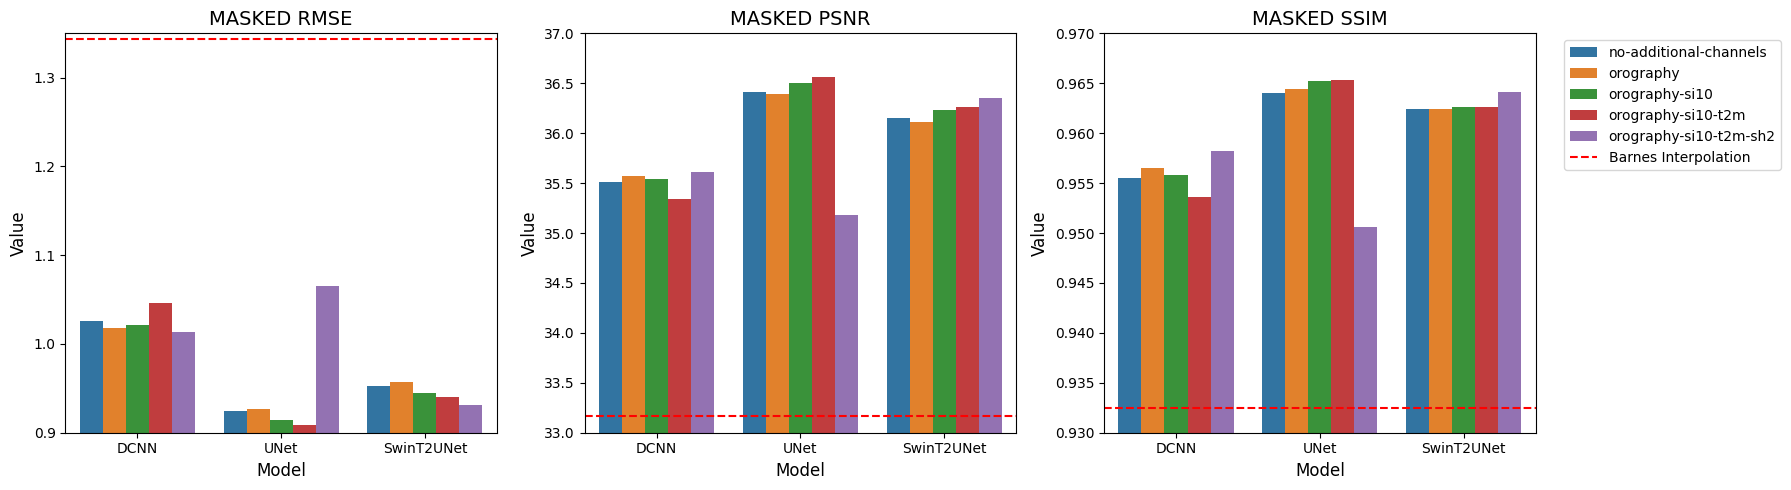

In [21]:
df = pd.read_csv("Sensitivity_to_input_channels.csv")
df_Barnes = pd.read_csv("Barnes_interpolated_metrics.csv")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

palette = sns.color_palette("tab10", n_colors=df['Experiment'].nunique())

ylims = {
    'masked_rmse': (0.9, 1.35),
    'masked_psnr': (33, 37),
    'masked_ssim': (0.93, 0.97)
}

for i, metric in enumerate(metrics):
    ax = axes[i]
    subset = df[df['Metric'] == metric]
    Barnes_ref = df_Barnes[(df_Barnes['Metric'] == metric) & (df_Barnes['Experiment'] == 'all-stations')]['Value'].values[0] 
    sns.barplot(
        data=subset,
        x='Model',
        y='Value',
        hue='Experiment',
        palette=palette,
        ax=ax
    )
    ax.axhline(y=Barnes_ref, color='red', linestyle='--', label='Barnes Interpolation')
    ax.set_title(metric.replace('_', ' ').upper(), fontsize=14)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    ax.tick_params(axis='x')
    if i == 2:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.get_legend().remove()
    ax.set_ylim(ylims[metric])

plt.tight_layout()
plt.show()

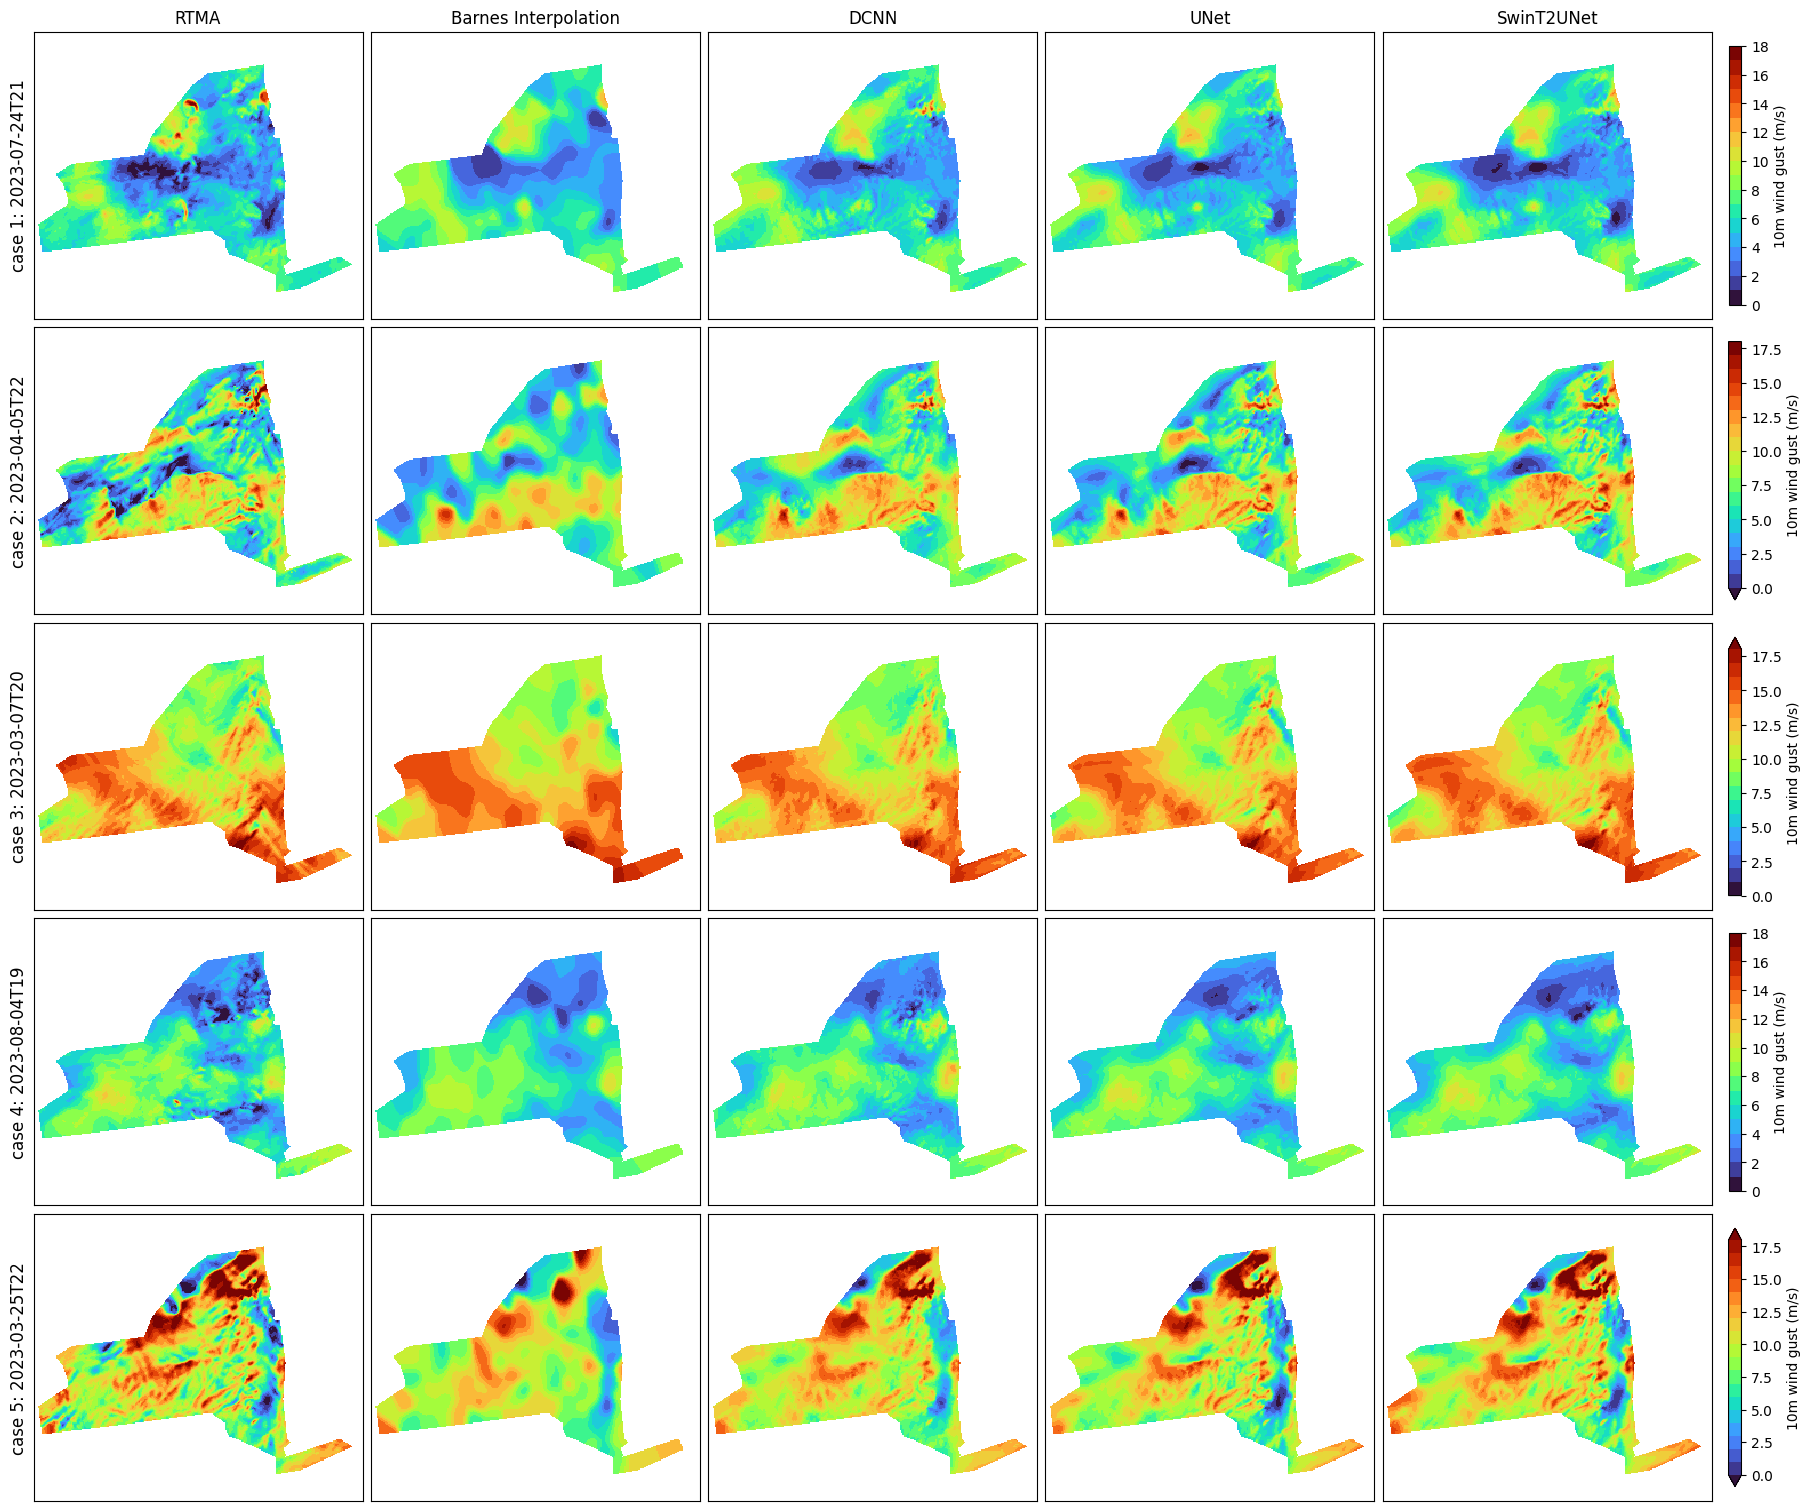

In [122]:
from matplotlib.colors import Normalize

# Setup
cmap = turbo_cmap
variable = 'i10fg'
mask = xr.open_dataset('mask_2d.nc').mask
levels = np.arange(0, 18.1, 1)
time_instances = ['2023-07-24T21',
                  '2023-04-05T22',
                  '2023-03-07T20',
                  '2023-08-04T19',
                  '2023-03-25T22']
fig, axes = plt.subplots(len(time_instances), 5, figsize=(18, 3*len(time_instances)), constrained_layout=True)

for i, time_instance in enumerate(time_instances):
    # Load data
    datasets = [
        ("RTMA", xr.open_zarr('data/RTMA.zarr')[variable].sel(time=time_instance)),
        ("Barnes Interpolation", xr.open_zarr('data/Barnes_interpolated/all-stations.zarr')[variable].sel(time=time_instance))
    ]

    experiment = 'orography'
    for model in ['DCNN', 'UNet', 'SwinT2UNet']:
        test_zarr_store = f'checkpoints/{variable}/{model}/{experiment}/2018-2021/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        ds = xr.open_zarr(test_zarr_store)[variable].sel(time=time_instance)
        datasets.append((model, ds))

    # Plot without individual colorbars
    norm = Normalize(vmin=levels.min(), vmax=levels.max())
    for j, (ax, (title, ds)) in enumerate(zip(axes[i,:], datasets)):
        img = ds.where(mask).plot(ax=ax, cmap=cmap, levels=levels, norm=norm, add_colorbar=False)
        ax.set_title(title, fontsize=12) if i == 0 else ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel(f'case {i+1}: {time_instance}', fontsize=12) if j == 0 else ax.set_ylabel('')

    # Add a single colorbar to the right of all subplots
    cbar = fig.colorbar(img, ax=axes[i,:], orientation='vertical',location='right', shrink=0.9, pad=0.01,label='10m wind gust (m/s)')


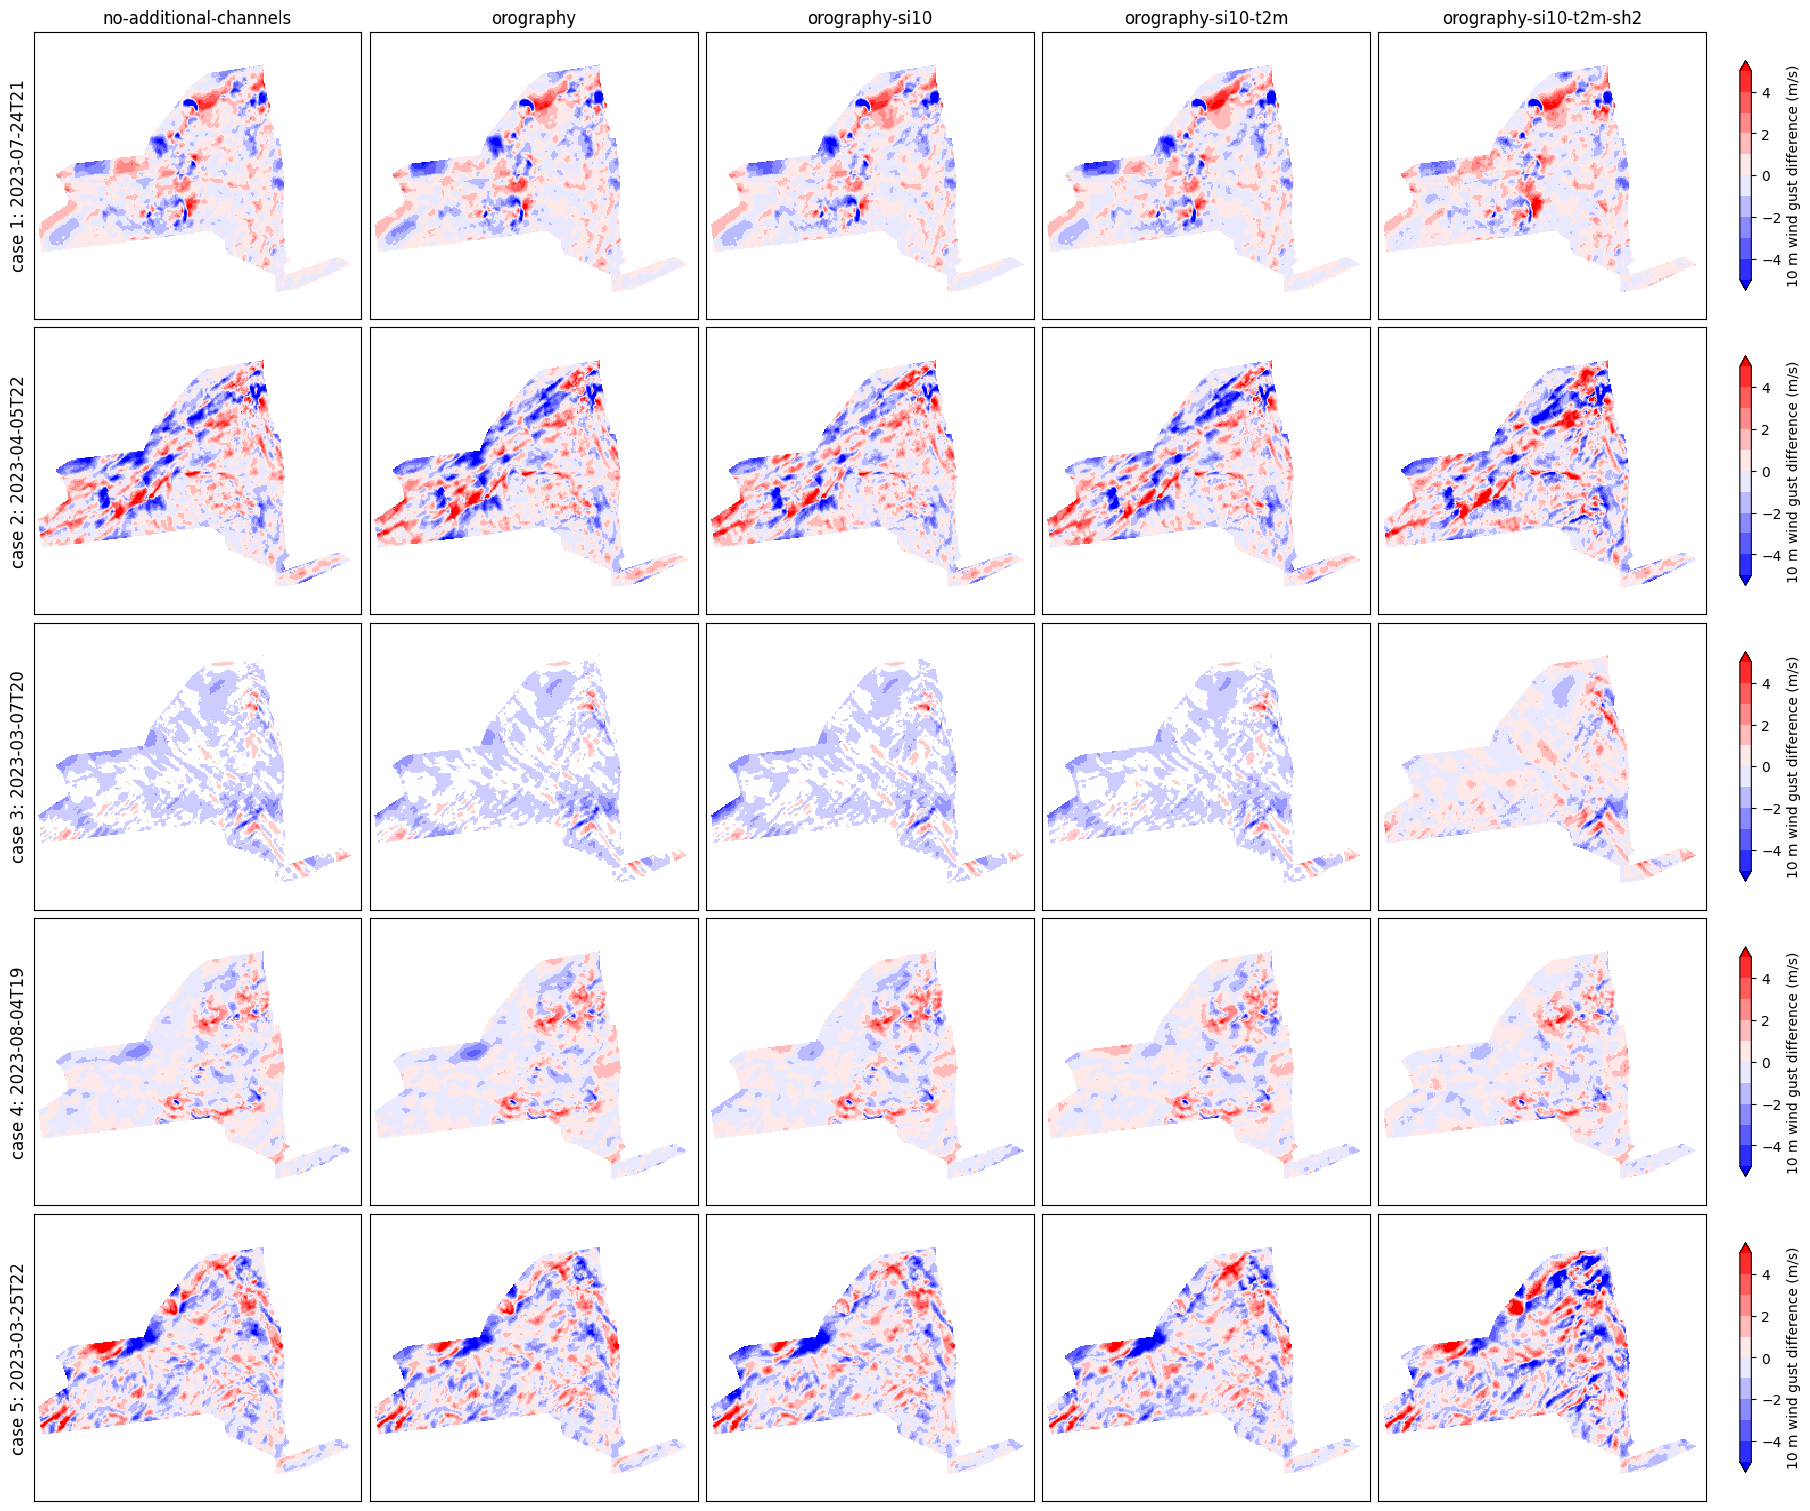

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import TwoSlopeNorm

cmap = 'bwr'  # blue-white-red for difference
variable = 'i10fg'
mask = xr.open_dataset('mask_2d.nc').mask

# Experiments to loop over
experiments = [
    'no-additional-channels',
    'orography',
    'orography-si10',
    'orography-si10-t2m',
    'orography-si10-t2m-sh2'
]

time_instances = ['2023-07-24T21',
                  '2023-04-05T22',
                  '2023-03-07T20',
                  '2023-08-04T19',
                  '2023-03-25T22']
fig, axes = plt.subplots(len(time_instances), 5, figsize=(18, 3*len(time_instances)), constrained_layout=True)
levels = np.arange(-5, 5.1, 1)
norm = TwoSlopeNorm(vmin=levels[0], vcenter=0, vmax=levels[-1])

for i, time_instance in enumerate(time_instances):
    # RTMA reference
    rtma = xr.open_zarr('data/RTMA.zarr')[variable].sel(time=time_instance)
    # Loop over experiments
    for j, exp in enumerate(experiments):
        ax = axes[i,j]
        test_zarr = f'checkpoints/{variable}/UNet/{exp}/2018-2021/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        pred = xr.open_zarr(test_zarr)[variable].sel(time=time_instance)

        diff = (pred - rtma).where(mask)

        im = diff.plot(
            ax=ax,
            cmap=cmap,
            levels=levels,
            norm=norm,
            add_colorbar=False
        )
        ax.set_title(exp, fontsize=12) if i == 0 else ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel(f'case {i+1}: {time_instance}', fontsize=12) if j == 0 else ax.set_ylabel('')

    # Shared colorbar
    fig.colorbar(im, ax=axes[i,:], orientation='vertical', location='right',
                shrink=0.8, pad=0.02, label='10 m wind gust difference (m/s)')

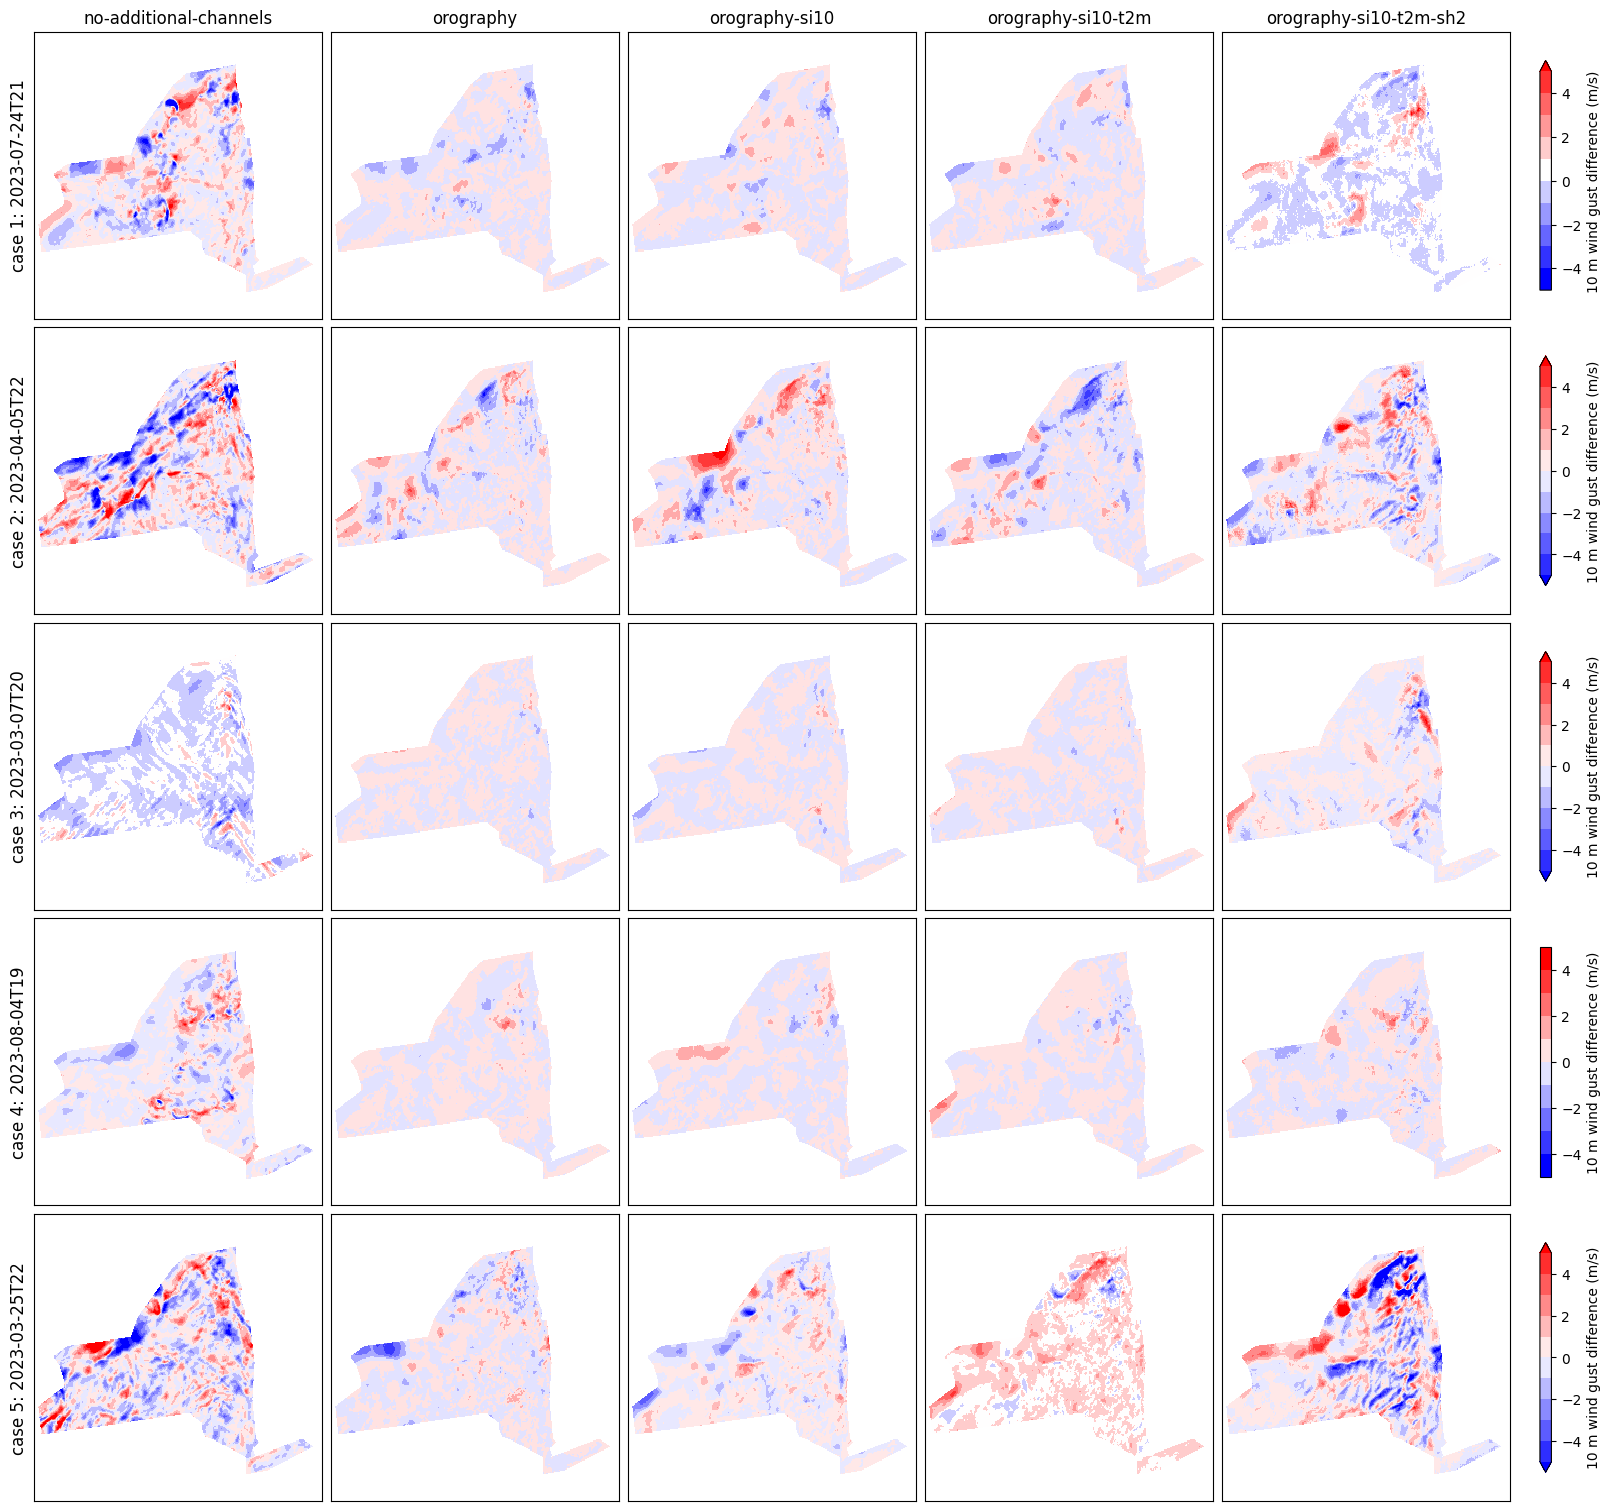

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import TwoSlopeNorm

cmap = 'bwr'  # blue-white-red for difference
variable = 'i10fg'
mask = xr.open_dataset('mask_2d.nc').mask

# Experiments to loop over
experiments = [
    'no-additional-channels',
    'orography',
    'orography-si10',
    'orography-si10-t2m',
    'orography-si10-t2m-sh2'
]

time_instances = ['2023-07-24T21',
                  '2023-04-05T22',
                  '2023-03-07T20',
                  '2023-08-04T19',
                  '2023-03-25T22']
fig, axes = plt.subplots(len(time_instances), len(experiments), figsize=(3*len(experiments)+1, 3*len(time_instances)), constrained_layout=True)
levels = np.arange(-5, 5.1, 1)
norm = TwoSlopeNorm(vmin=levels[0], vcenter=0, vmax=levels[-1])

for i, time_instance in enumerate(time_instances):
    # RTMA reference
    rtma = xr.open_zarr('data/RTMA.zarr')[variable].sel(time=time_instance)
    # Loop over experiments
    prev_pred = rtma
    for j, exp in enumerate(experiments):
        ax = axes[i,j]
        test_zarr = f'checkpoints/{variable}/UNet/{exp}/2018-2021/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        curr_pred = xr.open_zarr(test_zarr)[variable].sel(time=time_instance)

        diff = (curr_pred - prev_pred).where(mask)

        im = diff.plot(
            ax=ax,
            cmap=cmap,
            levels=levels,
            norm=norm,
            add_colorbar=False
        )
        ax.set_title(exp, fontsize=12) if i == 0 else ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel(f'case {i+1}: {time_instance}', fontsize=12) if j == 0 else ax.set_ylabel('')

        prev_pred = curr_pred

    # Shared colorbar
    fig.colorbar(im, ax=axes[i,:], orientation='vertical', location='right',
                shrink=0.8, pad=0.02, label='10 m wind gust difference (m/s)')

# Sensitivity experiments with years

In [27]:
results = []

station_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)
station_mask[y_indices, x_indices] = 1  # Set 1 at the station locations
print('Station mask shape:',station_mask.shape)
test_dates_range = ['2023-01-01T00','2023-12-31T23']
variable = 'i10fg'
missing_times = xr.open_dataset(f'nan_times_{variable}.nc').time
models = ['DCNN','UNet','SwinT2UNet']
experiments = ['2018',
               '2018-2019',
               '2018-2020']
for model in models:
    for experiment in experiments:
        test_zarr_store = f'checkpoints/{variable}/{model}/orography/{experiment}/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        target_ds = xr.open_zarr(zarr_store)[variable].sel(time=slice(*test_dates_range))
        pred_ds = xr.open_zarr(test_zarr_store)[variable].sel(time=slice(*test_dates_range))        
        # Convert [T, H, W] -> [B, 1, H, W]
        target_tensor = torch.tensor(target_ds.values, dtype=torch.float32).unsqueeze(1)
        pred_tensor = torch.tensor(pred_ds.values, dtype=torch.float32).unsqueeze(1)
        station_mask_tensor = torch.tensor(station_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(8760, -1, -1, -1)  # [8760, 1, H, W]
        #print('model:',model, 'experiment:',experiment, 'target shape:', target_tensor.shape, 'prediction shape:', pred_tensor.shape, 'station mask shape:', station_mask_tensor.shape)
        valid_instances = []
        nan_indices = []
        for t in range(pred_tensor.shape[0]):
            nansum = torch.isnan(pred_tensor[t,...]).sum().item()
            if nansum > 0:
                nan_indices.append(t)
                print(pred_ds.time[t].values)
            else:
                valid_instances.append(t)
        #print('nan_indices:',nan_indices)
        for key in metrics.keys():
            metric_value = metrics[key](pred_tensor[valid_instances,...], target_tensor[valid_instances,...], station_mask_tensor[valid_instances,...]).item()
            print(f'{model:>10} | {experiment:<30} | {key}: {metric_value:.4f}')

            # Save the results
            results.append({
                    "Model": model,
                    "Experiment": experiment,
                    "Metric": key,
                    "Value": metric_value
                })
# Convert to DataFrame and save
df_results = pd.DataFrame(results)
df_results.to_csv("Sensitivity_to_years.csv", index=False)

Station mask shape: (256, 288)
      DCNN | 2018                           | masked_rmse: 1.0700
      DCNN | 2018                           | masked_psnr: 35.1426
      DCNN | 2018                           | masked_ssim: 0.9516
      DCNN | 2018-2019                      | masked_rmse: 1.0552
      DCNN | 2018-2019                      | masked_psnr: 35.2642
      DCNN | 2018-2019                      | masked_ssim: 0.9532
      DCNN | 2018-2020                      | masked_rmse: 1.0382
      DCNN | 2018-2020                      | masked_psnr: 35.4048
      DCNN | 2018-2020                      | masked_ssim: 0.9547
      UNet | 2018                           | masked_rmse: 0.9756
      UNet | 2018                           | masked_psnr: 35.9455
      UNet | 2018                           | masked_ssim: 0.9596
      UNet | 2018-2019                      | masked_rmse: 0.9528
      UNet | 2018-2019                      | masked_psnr: 36.1509
      UNet | 2018-2019                  

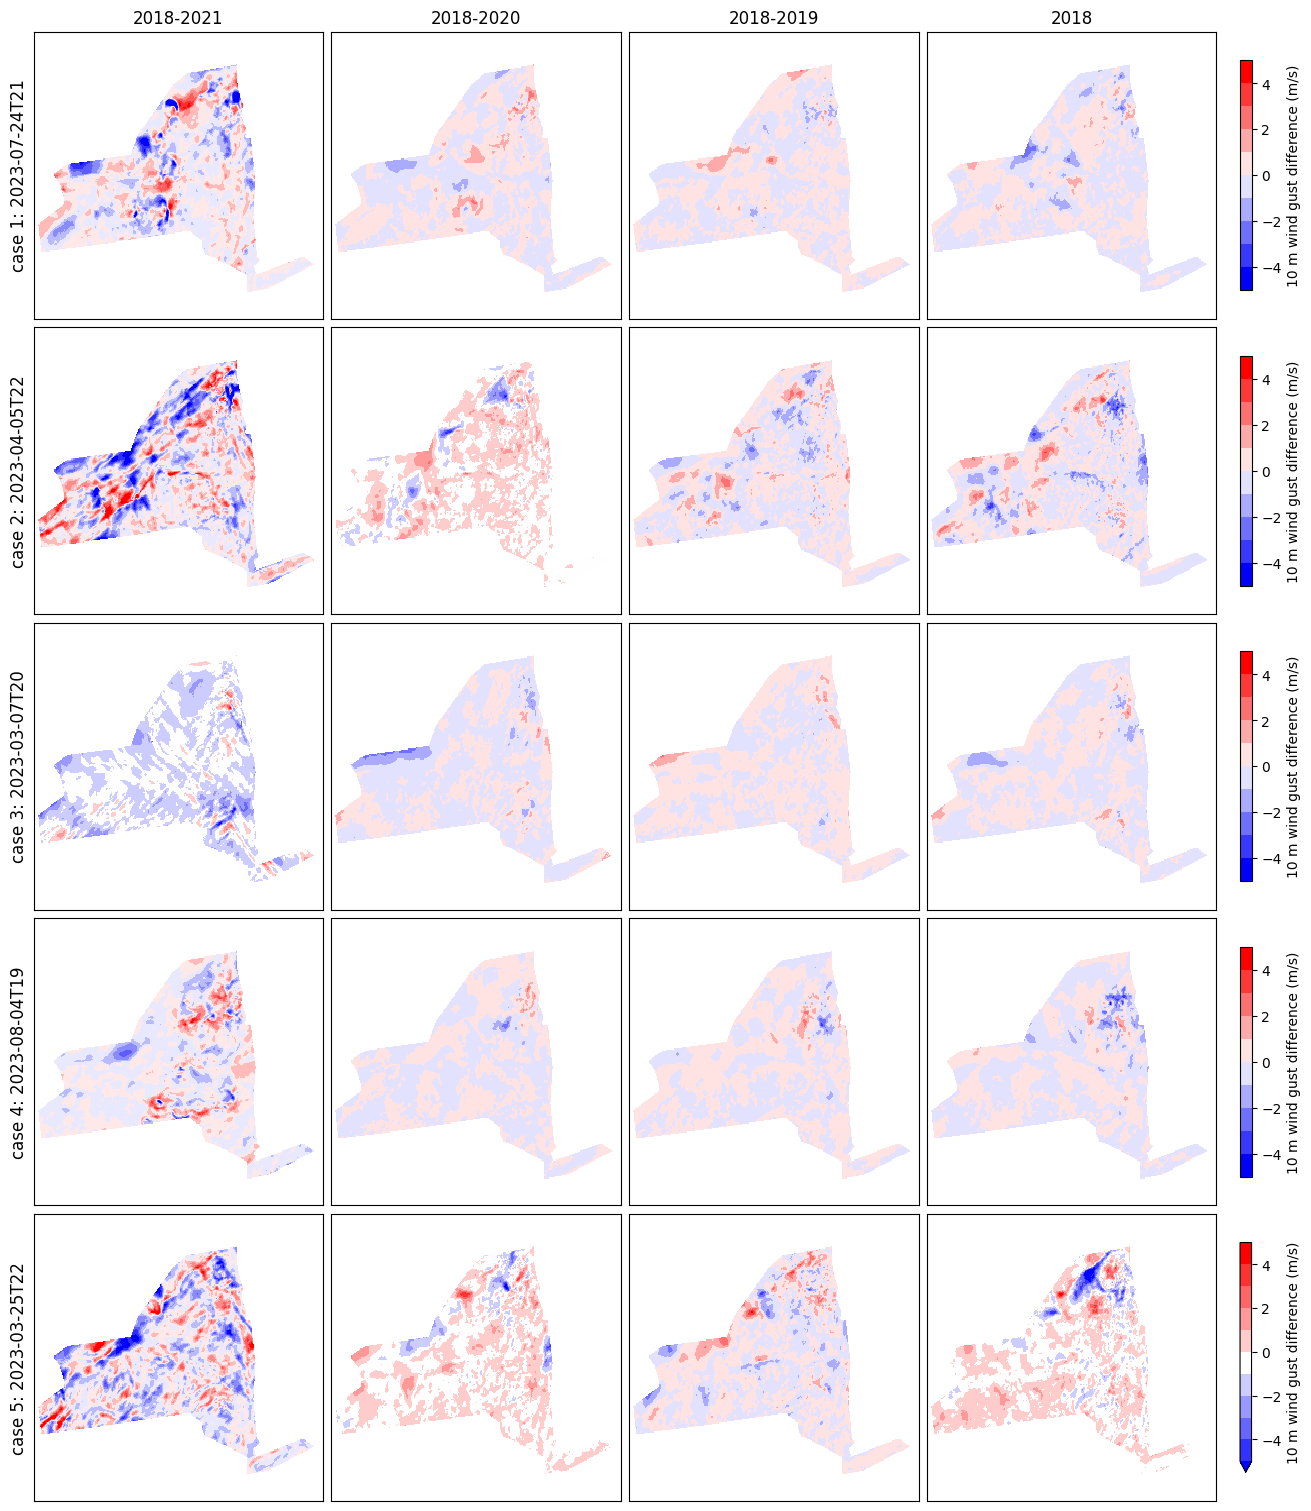

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import TwoSlopeNorm

cmap = 'bwr'  # blue-white-red for difference
variable = 'i10fg'
mask = xr.open_dataset('mask_2d.nc').mask

# Experiments to loop over
experiments = [
    '2018-2021',
    '2018-2020',
    '2018-2019',
    '2018']

time_instances = ['2023-07-24T21',
                  '2023-04-05T22',
                  '2023-03-07T20',
                  '2023-08-04T19',
                  '2023-03-25T22']
fig, axes = plt.subplots(len(time_instances), len(experiments), figsize=(3*len(experiments)+1, 3*len(time_instances)), constrained_layout=True)
levels = np.arange(-5, 5.1, 1)
norm = TwoSlopeNorm(vmin=levels[0], vcenter=0, vmax=levels[-1])

for i, time_instance in enumerate(time_instances):
    # RTMA reference
    rtma = xr.open_zarr('data/RTMA.zarr')[variable].sel(time=time_instance)
    # Loop over experiments
    prev_pred = rtma
    for j, exp in enumerate(experiments):
        ax = axes[i,j]
        test_zarr = f'checkpoints/{variable}/UNet/orography/{exp}/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        curr_pred = xr.open_zarr(test_zarr)[variable].sel(time=time_instance)

        diff = (curr_pred - prev_pred).where(mask)

        im = diff.plot(
            ax=ax,
            cmap=cmap,
            levels=levels,
            norm=norm,
            add_colorbar=False
        )
        ax.set_title(exp, fontsize=12) if i == 0 else ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel(f'case {i+1}: {time_instance}', fontsize=12) if j == 0 else ax.set_ylabel('')

        prev_pred = curr_pred

    # Shared colorbar
    fig.colorbar(im, ax=axes[i,:], orientation='vertical', location='right',
                shrink=0.8, pad=0.02, label='10 m wind gust difference (m/s)')

# Sensitivity experiments with number of stations

In [28]:
results = []

station_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)
station_mask[y_indices, x_indices] = 1  # Set 1 at the station locations
print('Station mask shape:',station_mask.shape)
test_dates_range = ['2023-01-01T00','2023-12-31T23']
variable = 'i10fg'
missing_times = xr.open_dataset(f'nan_times_{variable}.nc').time
models = ['DCNN','UNet','SwinT2UNet']
experiments = ['50-random-stations',
               '75-random-stations',
               '100-random-stations']
global_seed = 42
for model in models:
    for experiment in experiments:
        test_zarr_store = f'checkpoints/{variable}/{model}/orography/2018-2021/{global_seed}/{experiment}/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        target_ds = xr.open_zarr(zarr_store)[variable].sel(time=slice(*test_dates_range))
        pred_ds = xr.open_zarr(test_zarr_store)[variable].sel(time=slice(*test_dates_range))        
        # Convert [T, H, W] -> [B, 1, H, W]
        target_tensor = torch.tensor(target_ds.values, dtype=torch.float32).unsqueeze(1)
        pred_tensor = torch.tensor(pred_ds.values, dtype=torch.float32).unsqueeze(1)
        station_mask_tensor = torch.tensor(station_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(8760, -1, -1, -1)  # [8760, 1, H, W]
        #print('model:',model, 'experiment:',experiment, 'target shape:', target_tensor.shape, 'prediction shape:', pred_tensor.shape, 'station mask shape:', station_mask_tensor.shape)
        valid_instances = []
        nan_indices = []
        for t in range(pred_tensor.shape[0]):
            nansum = torch.isnan(pred_tensor[t,...]).sum().item()
            if nansum > 0:
                nan_indices.append(t)
                print(pred_ds.time[t].values)
            else:
                valid_instances.append(t)
        #print('nan_indices:',nan_indices)
        for key in metrics.keys():
            metric_value = metrics[key](pred_tensor[valid_instances,...], target_tensor[valid_instances,...], station_mask_tensor[valid_instances,...]).item()
            print(f'{model:>10} | {experiment:<30} | {key}: {metric_value:.4f}')

            # Save the results
            results.append({
                    "Model": model,
                    "Experiment": experiment,
                    "Metric": key,
                    "Value": metric_value
                })
# Convert to DataFrame and save
df_results = pd.DataFrame(results)
df_results.to_csv("Sensitivity_to_n_stations.csv", index=False)

Station mask shape: (256, 288)
      DCNN | 50-random-stations             | masked_rmse: 1.3035
      DCNN | 50-random-stations             | masked_psnr: 33.4283
      DCNN | 50-random-stations             | masked_ssim: 0.9388
      DCNN | 75-random-stations             | masked_rmse: 1.1561
      DCNN | 75-random-stations             | masked_psnr: 34.4704
      DCNN | 75-random-stations             | masked_ssim: 0.9467
      DCNN | 100-random-stations            | masked_rmse: 1.0821
      DCNN | 100-random-stations            | masked_psnr: 35.0455
      DCNN | 100-random-stations            | masked_ssim: 0.9521
      UNet | 50-random-stations             | masked_rmse: 1.2742
      UNet | 50-random-stations             | masked_psnr: 33.6262
      UNet | 50-random-stations             | masked_ssim: 0.9435
      UNet | 75-random-stations             | masked_rmse: 1.0639
      UNet | 75-random-stations             | masked_psnr: 35.1924
      UNet | 75-random-stations         

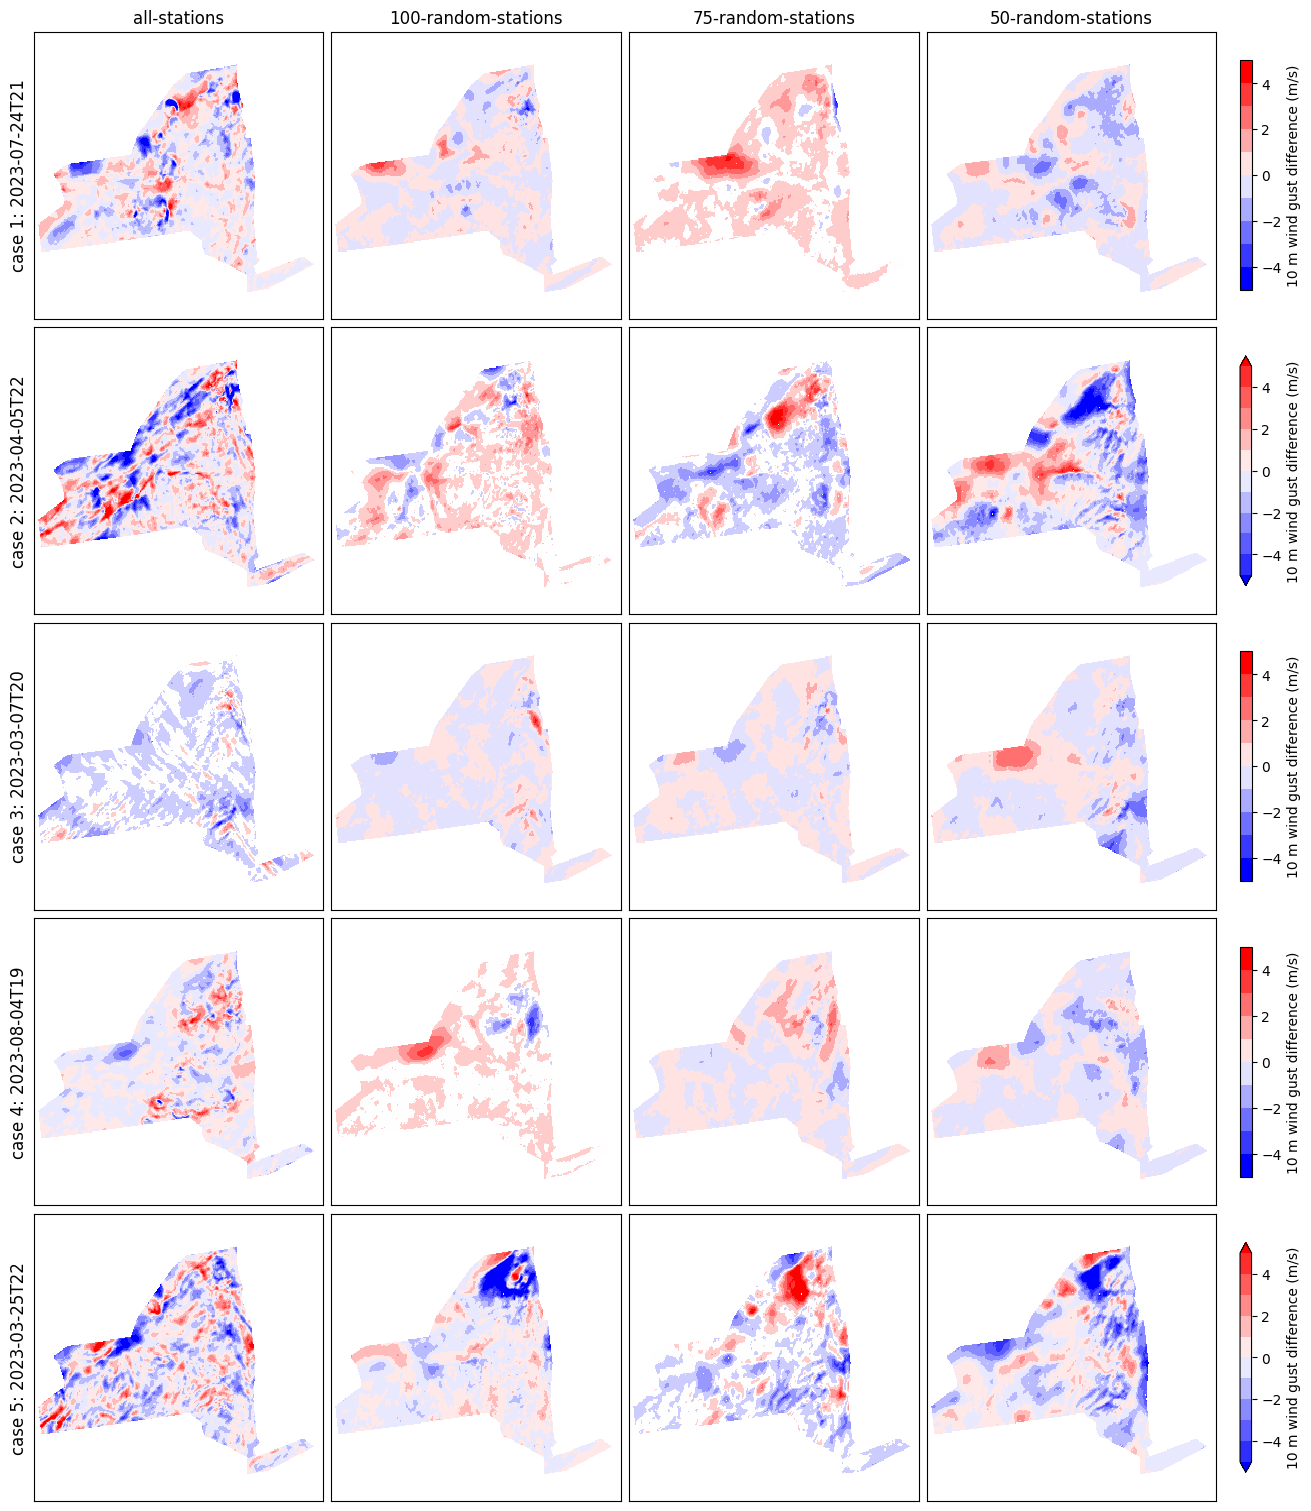

In [137]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import TwoSlopeNorm

cmap = 'bwr'  # blue-white-red for difference
variable = 'i10fg'
mask = xr.open_dataset('mask_2d.nc').mask

# Experiments to loop over
global_seed = 42
experiments = [
    'all-stations',
    f'{global_seed}/100-random-stations',
    f'{global_seed}/75-random-stations',
    f'{global_seed}/50-random-stations',
    ]


time_instances = ['2023-07-24T21',
                  '2023-04-05T22',
                  '2023-03-07T20',
                  '2023-08-04T19',
                  '2023-03-25T22']
fig, axes = plt.subplots(len(time_instances), len(experiments), figsize=(3*len(experiments)+1, 3*len(time_instances)), constrained_layout=True)
levels = np.arange(-5, 5.1, 1)
norm = TwoSlopeNorm(vmin=levels[0], vcenter=0, vmax=levels[-1])

for i, time_instance in enumerate(time_instances):
    # RTMA reference
    rtma = xr.open_zarr('data/RTMA.zarr')[variable].sel(time=time_instance)
    # Loop over experiments
    prev_pred = rtma
    for j, exp in enumerate(experiments):
        ax = axes[i,j]
        test_zarr = f'checkpoints/{variable}/UNet/orography/2018-2021/{exp}/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        curr_pred = xr.open_zarr(test_zarr)[variable].sel(time=time_instance)

        diff = (curr_pred - prev_pred).where(mask)

        im = diff.plot(
            ax=ax,
            cmap=cmap,
            levels=levels,
            norm=norm,
            add_colorbar=False
        )
        ax.set_title(exp.strip(f'{global_seed}/'), fontsize=12) if i == 0 else ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel(f'case {i+1}: {time_instance}', fontsize=12) if j == 0 else ax.set_ylabel('')

        prev_pred = curr_pred

    # Shared colorbar
    fig.colorbar(im, ax=axes[i,:], orientation='vertical', location='right',
                shrink=0.8, pad=0.02, label='10 m wind gust difference (m/s)')

# Generalization across different variables

In [29]:
results = []

station_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)
station_mask[y_indices, x_indices] = 1  # Set 1 at the station locations
print('Station mask shape:',station_mask.shape)
test_dates_range = ['2023-01-01T00','2023-12-31T23']
variables = ['si10','t2m','sh2']
missing_times = xr.open_dataset(f'nan_times_{variable}.nc').time
models = ['DCNN','UNet','SwinT2UNet']
experiments = ['50-random-stations',
               '75-random-stations',
               '100-random-stations']
global_seed = 42

for model in models:
    for variable in variables:
        test_zarr_store = f'checkpoints/{variable}/{model}/orography/2018-2021/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        target_ds = xr.open_zarr(zarr_store)[variable].sel(time=slice(*test_dates_range))
        pred_ds = xr.open_zarr(test_zarr_store)[variable].sel(time=slice(*test_dates_range))        
        # Convert [T, H, W] -> [B, 1, H, W]
        target_tensor = torch.tensor(target_ds.values, dtype=torch.float32).unsqueeze(1)
        pred_tensor = torch.tensor(pred_ds.values, dtype=torch.float32).unsqueeze(1)
        station_mask_tensor = torch.tensor(station_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(8760, -1, -1, -1)  # [8760, 1, H, W]
        #print('model:',model, 'experiment:',experiment, 'target shape:', target_tensor.shape, 'prediction shape:', pred_tensor.shape, 'station mask shape:', station_mask_tensor.shape)
        valid_instances = []
        nan_indices = []
        for t in range(pred_tensor.shape[0]):
            nansum = torch.isnan(pred_tensor[t,...]).sum().item()
            if nansum > 0:
                nan_indices.append(t)
                print(pred_ds.time[t].values)
            else:
                valid_instances.append(t)
        #print('nan_indices:',nan_indices)
        for key in metrics.keys():
            metric_value = metrics[key](pred_tensor[valid_instances,...], target_tensor[valid_instances,...], station_mask_tensor[valid_instances,...]).item()
            print(f'{model:>10} | {variable:<30} | {key}: {metric_value:.4f}')

            # Save the results
            results.append({
                    "Model": model,
                    "variable": variable,
                    "Metric": key,
                    "Value": metric_value
                })
# Convert to DataFrame and save
df_results = pd.DataFrame(results)
df_results.to_csv("Generalization_across_variables.csv", index=False)

Station mask shape: (256, 288)
2023-01-17T16:00:00.000000000
      DCNN | si10                           | masked_rmse: 0.9095
      DCNN | si10                           | masked_psnr: 33.1284
      DCNN | si10                           | masked_ssim: 0.9349
      DCNN | t2m                            | masked_rmse: 0.8709
      DCNN | t2m                            | masked_psnr: 55.9713
      DCNN | t2m                            | masked_ssim: 0.9997
      DCNN | sh2                            | masked_rmse: 0.0003
      DCNN | sh2                            | masked_psnr: 41.0389
      DCNN | sh2                            | masked_ssim: 0.9886
2023-01-17T16:00:00.000000000
      UNet | si10                           | masked_rmse: 0.9852
      UNet | si10                           | masked_psnr: 32.4342
      UNet | si10                           | masked_ssim: 0.9170
      UNet | t2m                            | masked_rmse: 0.5838
      UNet | t2m                            | m

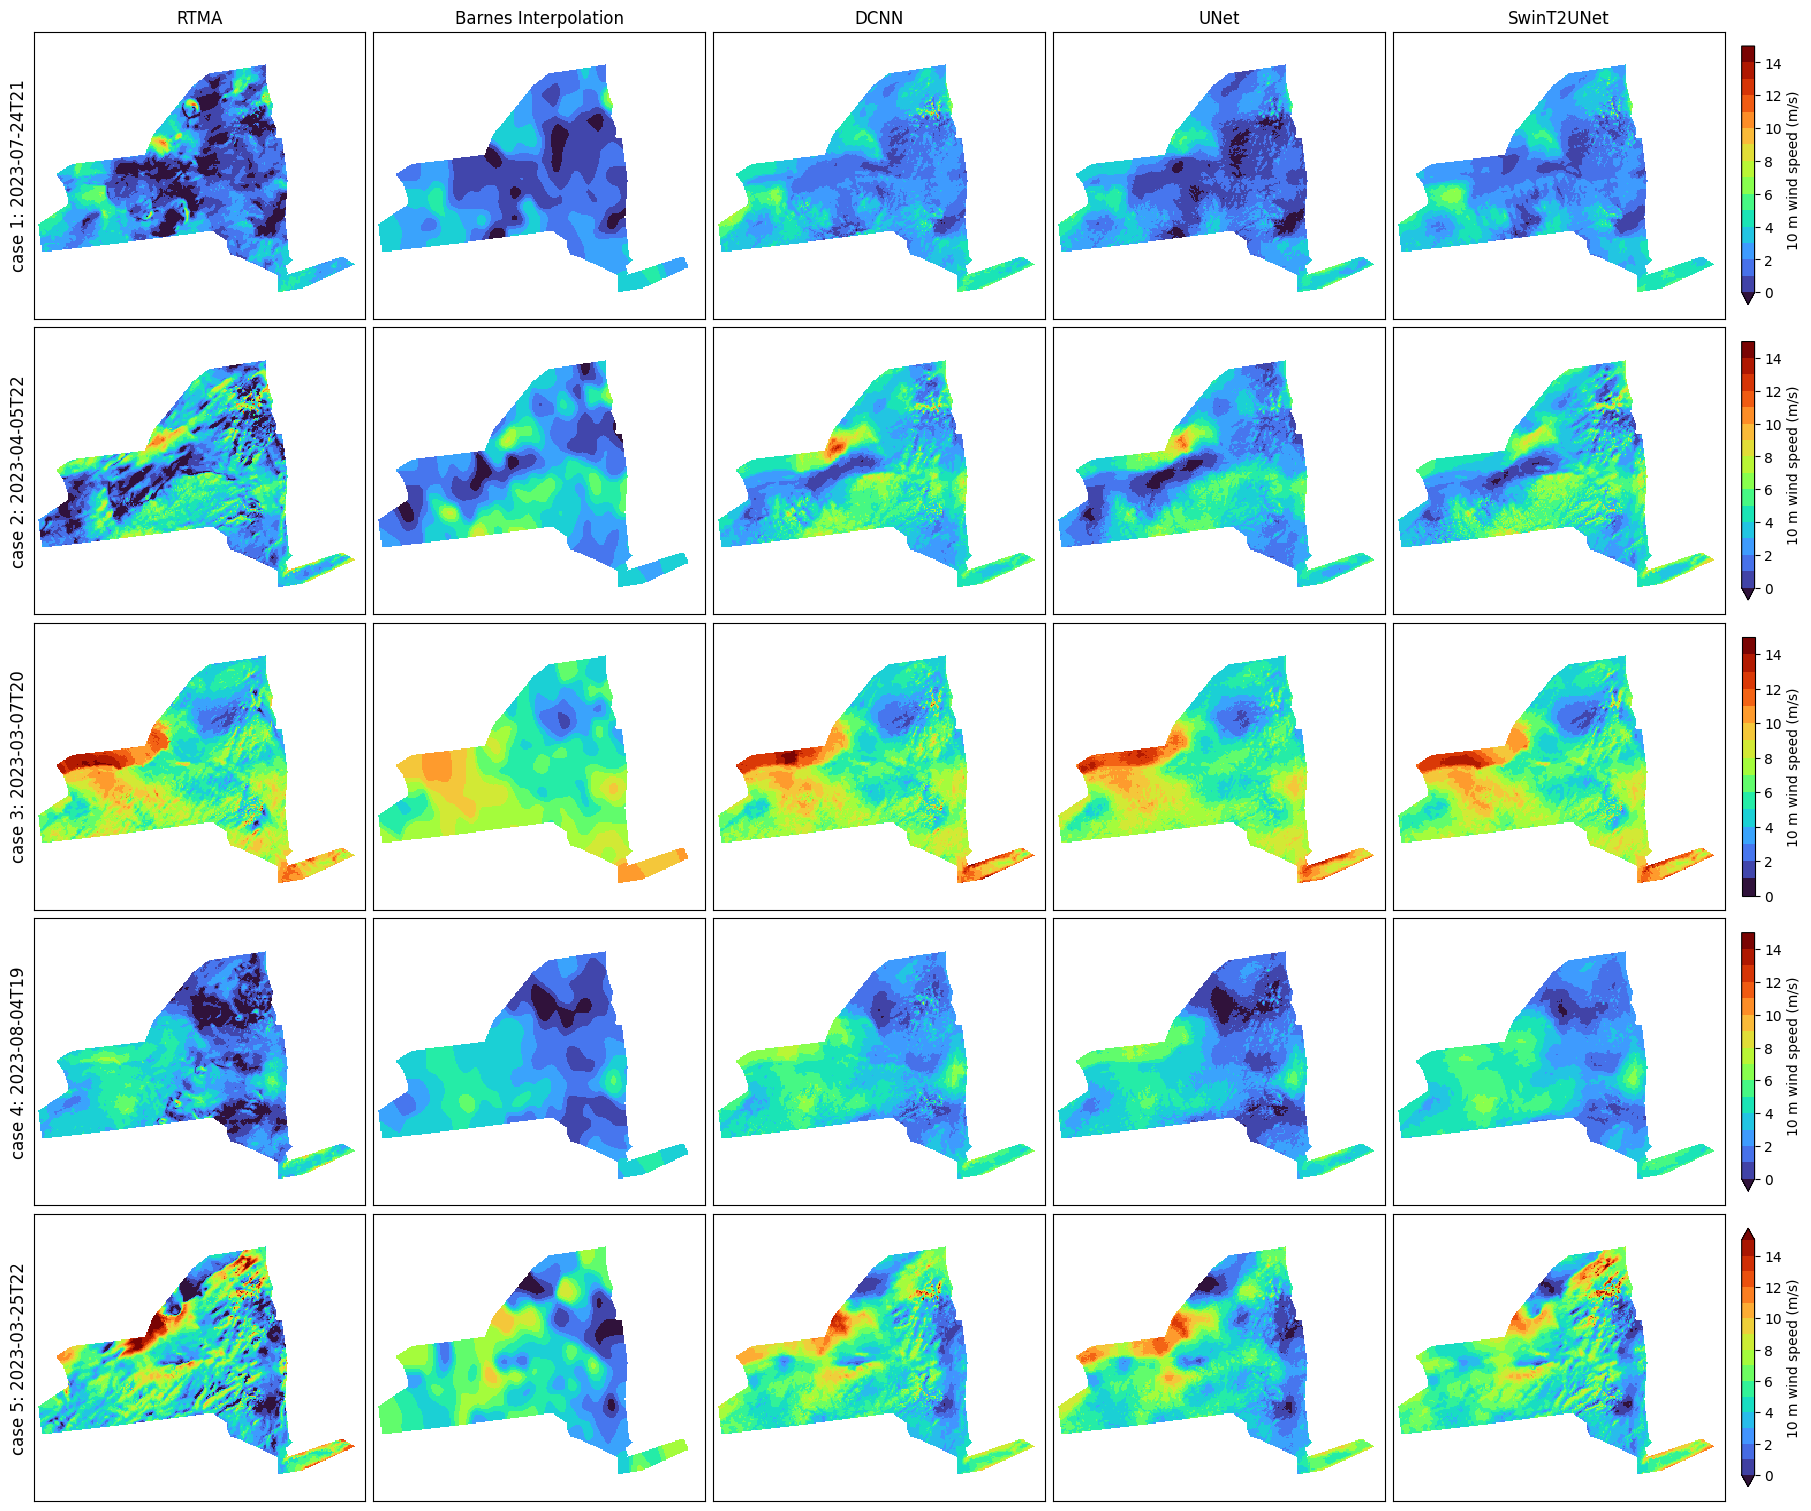

In [8]:
from matplotlib.colors import Normalize

# Setup
cmap = turbo_cmap
variable = 'si10'
mask = xr.open_dataset('mask_2d.nc').mask
levels = np.arange(0, 15.1, 1)
time_instances = ['2023-07-24T21',
                  '2023-04-05T22',
                  '2023-03-07T20',
                  '2023-08-04T19',
                  '2023-03-25T22']
fig, axes = plt.subplots(len(time_instances), 5, figsize=(18, 3*len(time_instances)), constrained_layout=True)

for i, time_instance in enumerate(time_instances):
    # Load data
    datasets = [
        ("RTMA", xr.open_zarr('data/RTMA.zarr')[variable].sel(time=time_instance)),
        ("Barnes Interpolation", xr.open_zarr('data/Barnes_interpolated/all-stations.zarr')[variable].sel(time=time_instance))
    ]

    experiment = 'orography'
    for model in ['DCNN', 'UNet', 'SwinT2UNet']:
        test_zarr_store = f'checkpoints/{variable}/{model}/{experiment}/2018-2021/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        ds = xr.open_zarr(test_zarr_store)[variable].sel(time=time_instance)
        datasets.append((model, ds))

    # Plot without individual colorbars
    norm = Normalize(vmin=levels.min(), vmax=levels.max())
    for j, (ax, (title, ds)) in enumerate(zip(axes[i,:], datasets)):
        img = ds.where(mask).plot(ax=ax, cmap=cmap, levels=levels, norm=norm, add_colorbar=False)
        ax.set_title(title, fontsize=12) if i == 0 else ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel(f'case {i+1}: {time_instance}', fontsize=12) if j == 0 else ax.set_ylabel('')

    # Add a single colorbar to the right of all subplots
    cbar = fig.colorbar(img, ax=axes[i,:], orientation='vertical',location='right', shrink=0.9, pad=0.01,label='10 m wind speed (m/s)')


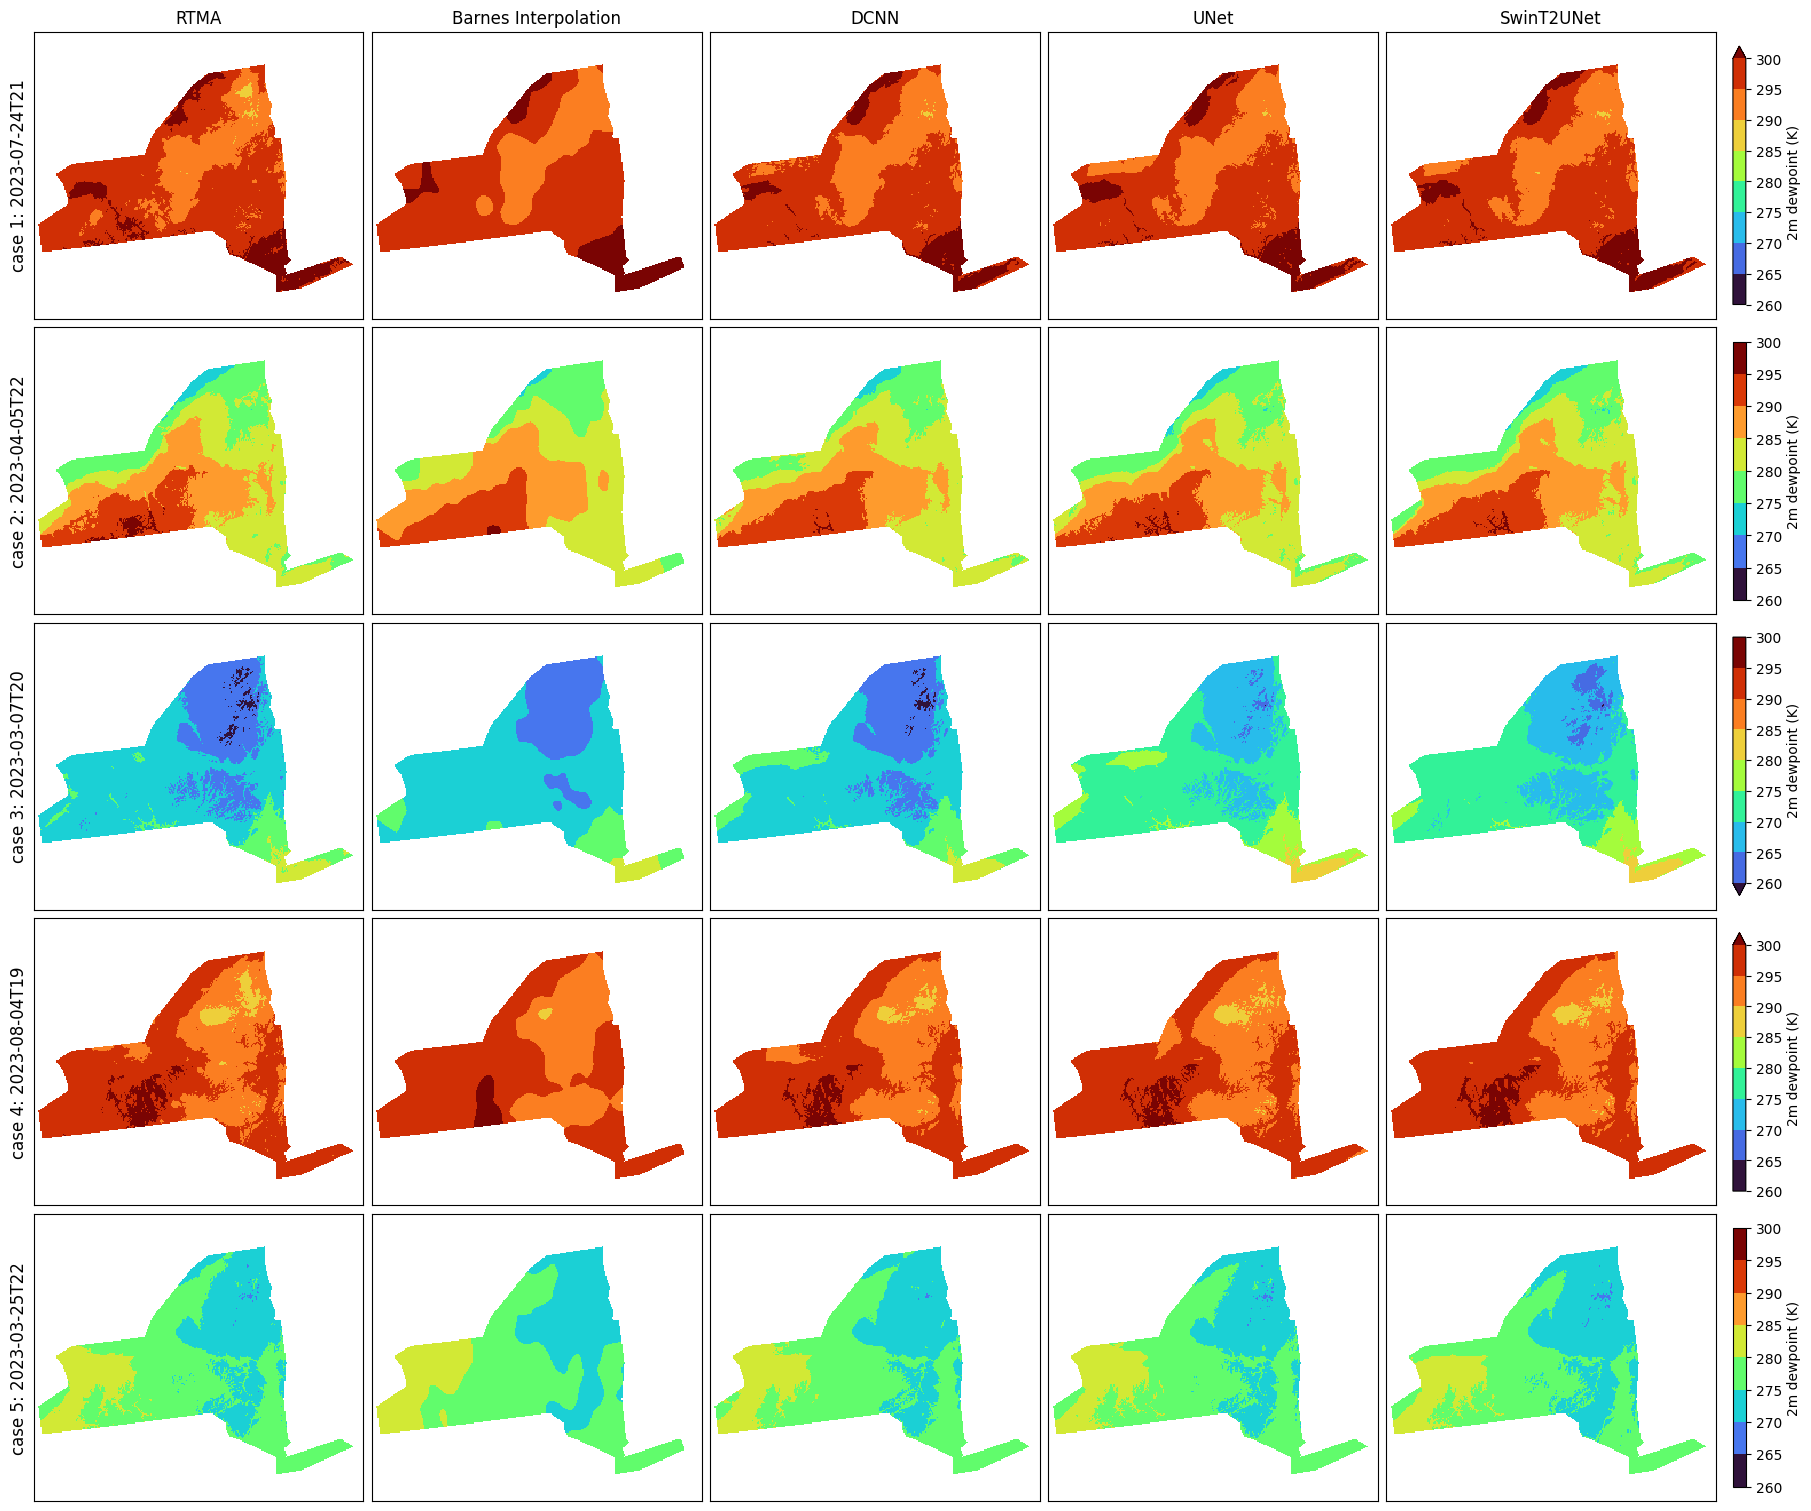

In [9]:
from matplotlib.colors import Normalize

# Setup
cmap = turbo_cmap
variable = 't2m'
mask = xr.open_dataset('mask_2d.nc').mask
levels = np.arange(260, 300.1, 5)
time_instances = ['2023-07-24T21',
                  '2023-04-05T22',
                  '2023-03-07T20',
                  '2023-08-04T19',
                  '2023-03-25T22']
fig, axes = plt.subplots(len(time_instances), 5, figsize=(18, 3*len(time_instances)), constrained_layout=True)

for i, time_instance in enumerate(time_instances):
    # Load data
    datasets = [
        ("RTMA", xr.open_zarr('data/RTMA.zarr')[variable].sel(time=time_instance)),
        ("Barnes Interpolation", xr.open_zarr('data/Barnes_interpolated/all-stations.zarr')[variable].sel(time=time_instance))
    ]

    experiment = 'orography'
    for model in ['DCNN', 'UNet', 'SwinT2UNet']:
        test_zarr_store = f'checkpoints/{variable}/{model}/{experiment}/2018-2021/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        ds = xr.open_zarr(test_zarr_store)[variable].sel(time=time_instance)
        datasets.append((model, ds))

    # Plot without individual colorbars
    norm = Normalize(vmin=levels.min(), vmax=levels.max())
    for j, (ax, (title, ds)) in enumerate(zip(axes[i,:], datasets)):
        img = ds.where(mask).plot(ax=ax, cmap=cmap, levels=levels, norm=norm, add_colorbar=False)
        ax.set_title(title, fontsize=12) if i == 0 else ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel(f'case {i+1}: {time_instance}', fontsize=12) if j == 0 else ax.set_ylabel('')

    # Add a single colorbar to the right of all subplots
    cbar = fig.colorbar(img, ax=axes[i,:], orientation='vertical',location='right', shrink=0.9, pad=0.01,label='2m dewpoint (K)')

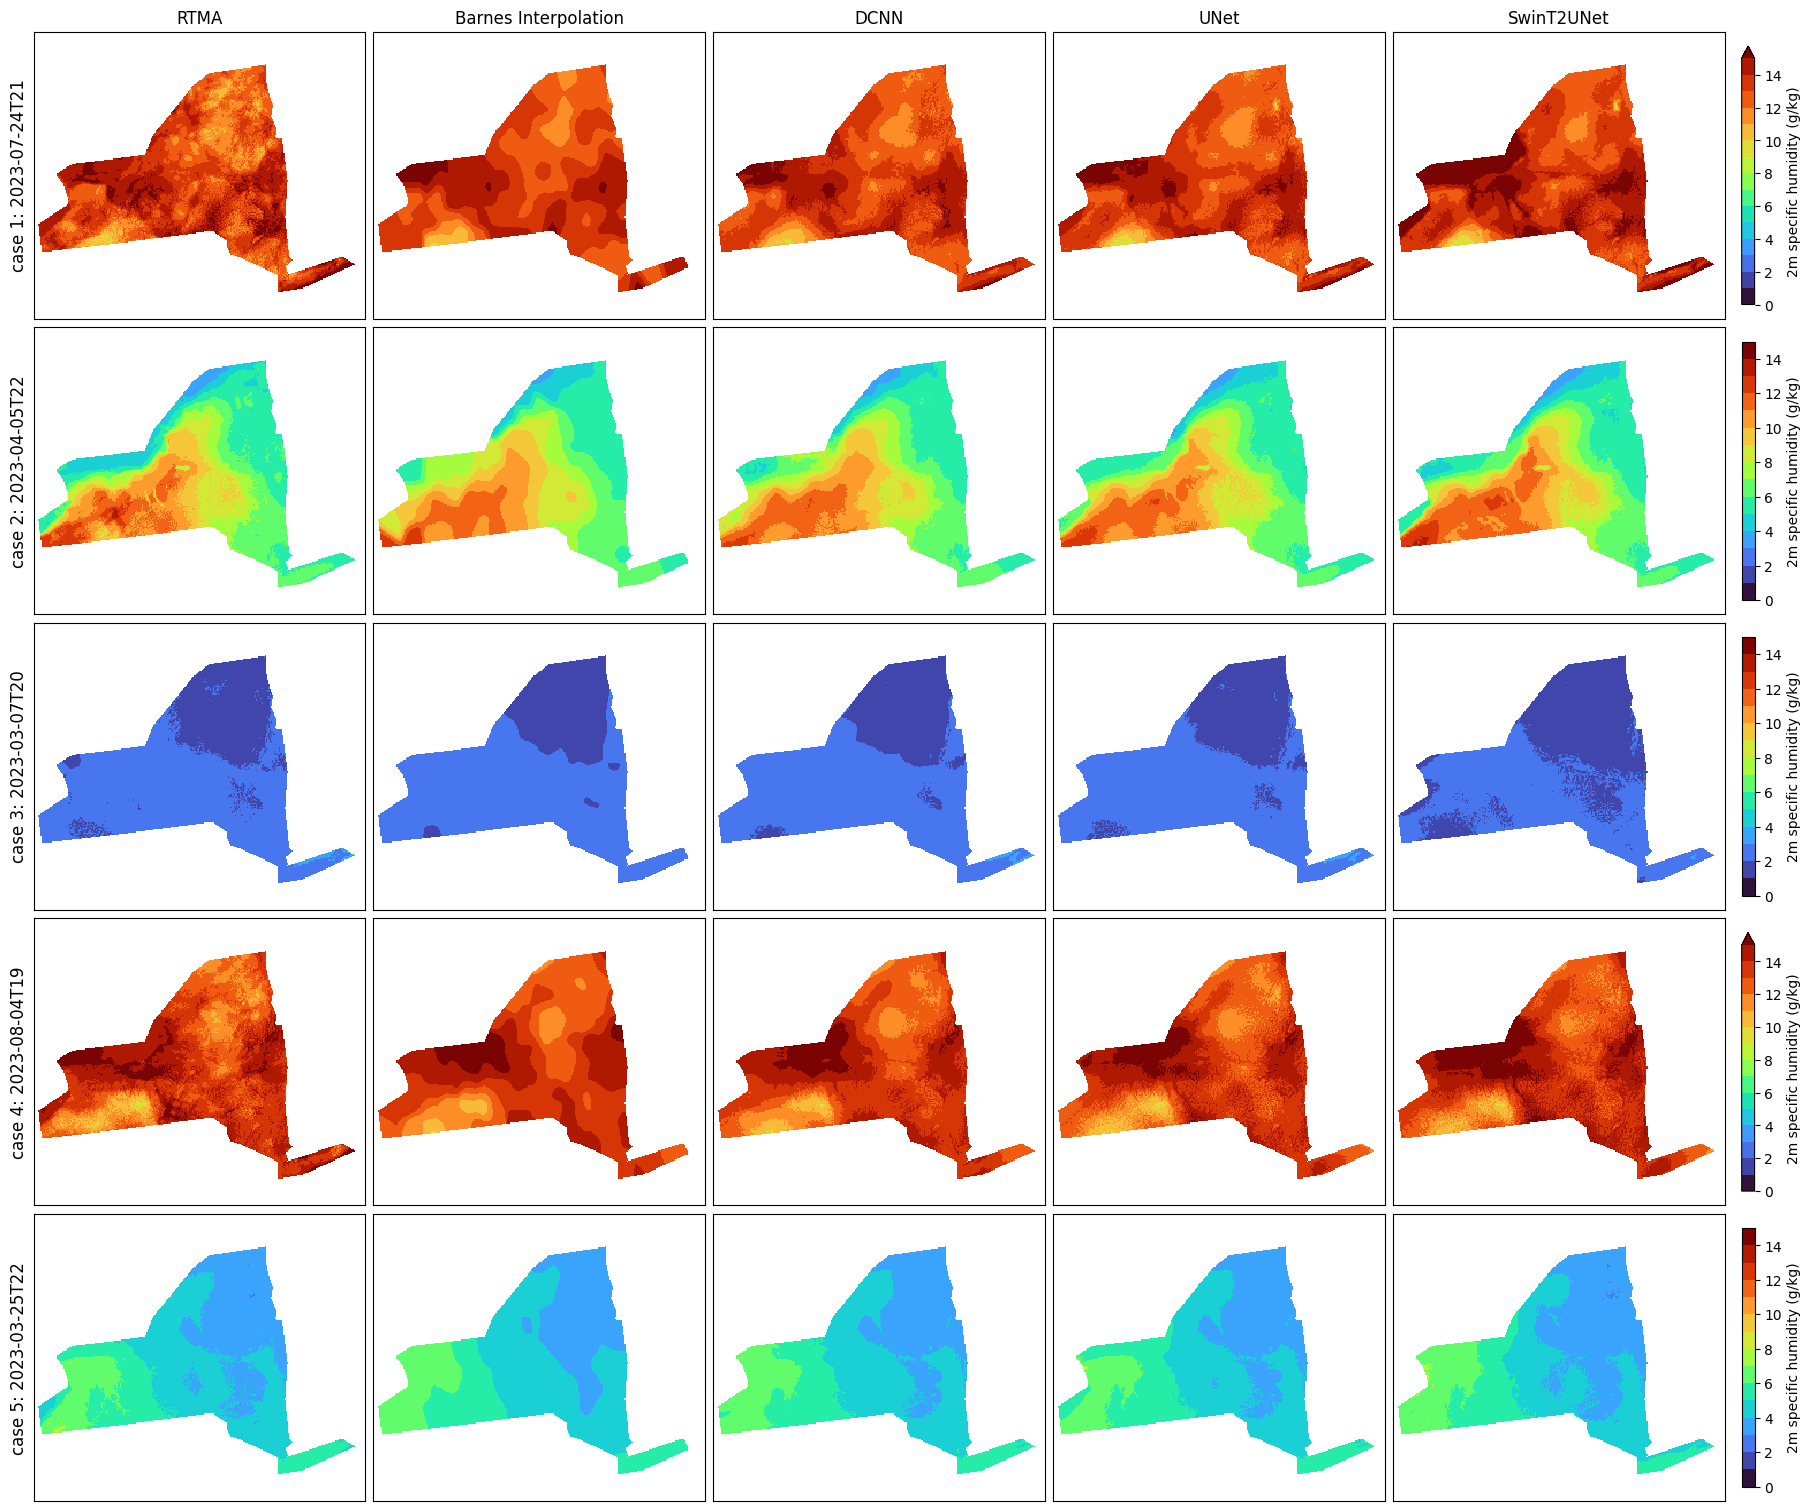

In [10]:
from matplotlib.colors import Normalize

# Setup
cmap = turbo_cmap
variable = 'sh2'
mask = xr.open_dataset('mask_2d.nc').mask
levels = np.arange(0, 15.1, 1)
time_instances = ['2023-07-24T21',
                  '2023-04-05T22',
                  '2023-03-07T20',
                  '2023-08-04T19',
                  '2023-03-25T22']
fig, axes = plt.subplots(len(time_instances), 5, figsize=(18, 3*len(time_instances)), constrained_layout=True)

for i, time_instance in enumerate(time_instances):
    # Load data
    datasets = [
        ("RTMA", xr.open_zarr('data/RTMA.zarr')[variable].sel(time=time_instance)),
        ("Barnes Interpolation", xr.open_zarr('data/Barnes_interpolated/all-stations.zarr')[variable].sel(time=time_instance))
    ]

    experiment = 'orography'
    for model in ['DCNN', 'UNet', 'SwinT2UNet']:
        test_zarr_store = f'checkpoints/{variable}/{model}/{experiment}/2018-2021/all-stations/MaskedCharbonnierLoss/standard/RTMA_test.zarr'
        ds = xr.open_zarr(test_zarr_store)[variable].sel(time=time_instance)
        datasets.append((model, ds))

    # Plot without individual colorbars
    norm = Normalize(vmin=levels.min(), vmax=levels.max())
    for j, (ax, (title, ds)) in enumerate(zip(axes[i,:], datasets)):
        img = (ds*1e3).where(mask).plot(ax=ax, cmap=cmap, levels=levels, norm=norm, add_colorbar=False)
        ax.set_title(title, fontsize=12) if i == 0 else ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel(f'case {i+1}: {time_instance}', fontsize=12) if j == 0 else ax.set_ylabel('')

    # Add a single colorbar to the right of all subplots
    cbar = fig.colorbar(img, ax=axes[i,:], orientation='vertical',location='right', shrink=0.9, pad=0.01,label='2m specific humidity (g/kg)')